In [1]:


import argparse
import concurrent.futures
import glob
import json
import logging
import os
import sys
import time
from typing import Dict, List, Tuple

import pandas as pd

from cpom.areas.area_plot import Polarplot
from cpom.gridding.gridareas import GridArea
from cpom.logging_funcs.logging import set_loggers

log = logging.getLogger(__name__)

SECONDS_PER_YEAR = 3600.0 * 24.0 * 365.25  # approximate

In [106]:
import duckdb
import polars as pl

conn = duckdb.connect()
griddir = "/home/willisc3/luna/CPOM/willisc3/EOCIS/altimetry/landice/gridded_altimetry/cs2/greenland_5km_cryotempo_li/"
parquet_glob = f"{griddir}/**/*.parquet"

def get_stats_per_grid_cell(griddir:str, compacted:bool) -> pl.DataFrame:
    """
    Get statistics per grid cell from the parquet files.
    """
    if compacted:
        if "compacted" in griddir:
            parquet_glob = f"{griddir}/**/*.parquet"
        else:
            log.warning("Compacted grid directory does not match expected pattern.")
            parquet_glob = f"{griddir}/compacted/**/*.parquet"
    else:
        parquet_glob = f"{griddir}/year=*/**/*.parquet"

    tbl = conn.execute(f""" 
                SELECT 
                x_bin, 
                y_bin,
                mean(elevation) as mean_elev,
                (MAX(time) - MIN(time)) / {SECONDS_PER_YEAR} AS coverage_yrs,
                count(*) as n_elev,
                x_part,
                y_part,
                FROM parquet_scan('{parquet_glob}')
                group by x_part, y_part, x_bin , y_bin, 
                order by x_bin, y_bin
    """).pl()

    return tbl 

def get_grid_and_metadata(griddir: str) -> Tuple[GridArea, Dict]:
    with open(griddir + "grid_meta.json", "r") as f:
        grid_meta = json.load(f)
            
    if "grid_name" in grid_meta and "bin_size" in grid_meta:
        grid = GridArea(grid_meta["grid_name"], int(grid_meta["bin_size"]))
        grid.info()

    return grid, grid_meta

def attach_xy_latlon(df: pl.DataFrame, grid: GridArea) -> pl.DataFrame:
    """
    Attach x_center, y_center, lat_center, lon_center columns to a DataFrame
    that has [x_bin, y_bin].
    """
    if len(df) == 0  or grid is None:
        return df

    df = df.with_columns((pl.col("x_bin") * grid.binsize + grid.minxm + (grid.binsize / 2)).alias("x_centre"), 
                           (pl.col("y_bin") * grid.binsize + grid.minym + (grid.binsize / 2)).alias("y_centre"))


    lat_arr, lon_arr = grid.transform_x_y_to_lat_lon(df["x_centre"].to_numpy(), df["y_centre"].to_numpy())

    df = df.with_columns(
                    pl.Series("lat_centre", lat_arr),
                    pl.Series("lon_centre", lon_arr))

    return df


In [104]:
def plot_variable(
    df: pd.DataFrame,
    grid_meta: dict,
    var_name: str = "mean_elev",
    plot_file: str = "",
):
    """
    Plot a chosen variable (column in df), e.g. "mean_elev" or "coverage_yrs",
    as points using Polarplot.
    """
    if len(df) == 0:
        log.info("No data to plot.")
        return

    if var_name not in df.columns:
        log.error(
            "Requested plot_var '%s' not found in DataFrame columns: %s", var_name, df.columns
        )
        return

    area_name = grid_meta.get("area_filter", "antarctica_is")  # fallback if missing
    dataset_for_plot = {
        "lats": df.select(["lat_centre"]).to_numpy(),
        "lons": df.select(["lon_centre"]).to_numpy(),
        "vals": df.select([var_name]).to_numpy(),
        "name": var_name,
        "plot_size_scale_factor": 0.1,
    }

    log.info("Plotting '%s' for %d grid cells.", var_name, len(df))
    polar = Polarplot(area_name)
    polar.plot_points(dataset_for_plot, output_file=plot_file)

    if plot_file:
        log.info("Saved plot to: %s", plot_file)



In [96]:
tbl = get_stats_per_grid_cell(griddir, compacted=True)
grid , grid_meta = get_grid_and_metadata(griddir)
tbl = attach_xy_latlon(tbl, grid)

Compacted grid directory does not match expected pattern.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Grid Name :  greenland
    Grid Long Name :  Greenland
    Grid CRS :  epsg:3413
    Width (in X) :  2100000.0 (m)
    Height (in Y) :  3100000.0 (m)
    Bottom left coordinates (min x,y):  -1000000.0 -3500000.0 (m)
Binsize 5000  (m)
Ncols, Nrows= (420, 620)


In [ ]:
tbl.write_parquet(args.output_file, compression="zstd")

-------------------------------------------------------------
Background: basic_land
alpha= 1.0
Loading basic_land background
-------------------------------------------------------------
71.5 -41.75
(-655426.9213693695, 884573.0786306305)
(-3387695.941429183, -647695.9414291831)
display_polygon_mask False
loading data set 0: mean_elev
-------------------------------------------------------------
Background: basic_land
alpha= 1.0
Loading basic_land background
-------------------------------------------------------------


/home/willisc3/luna/CPOM/willisc3/cpom_software2/src/cpom/areas/area_plot.py:1509: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(tick_labels)


drawing coastline for main map..
Adding map scale bar
Scalebar location latlon == x,y -35 60 577060.7250919531 -3272673.999029407
Scalebar width 400


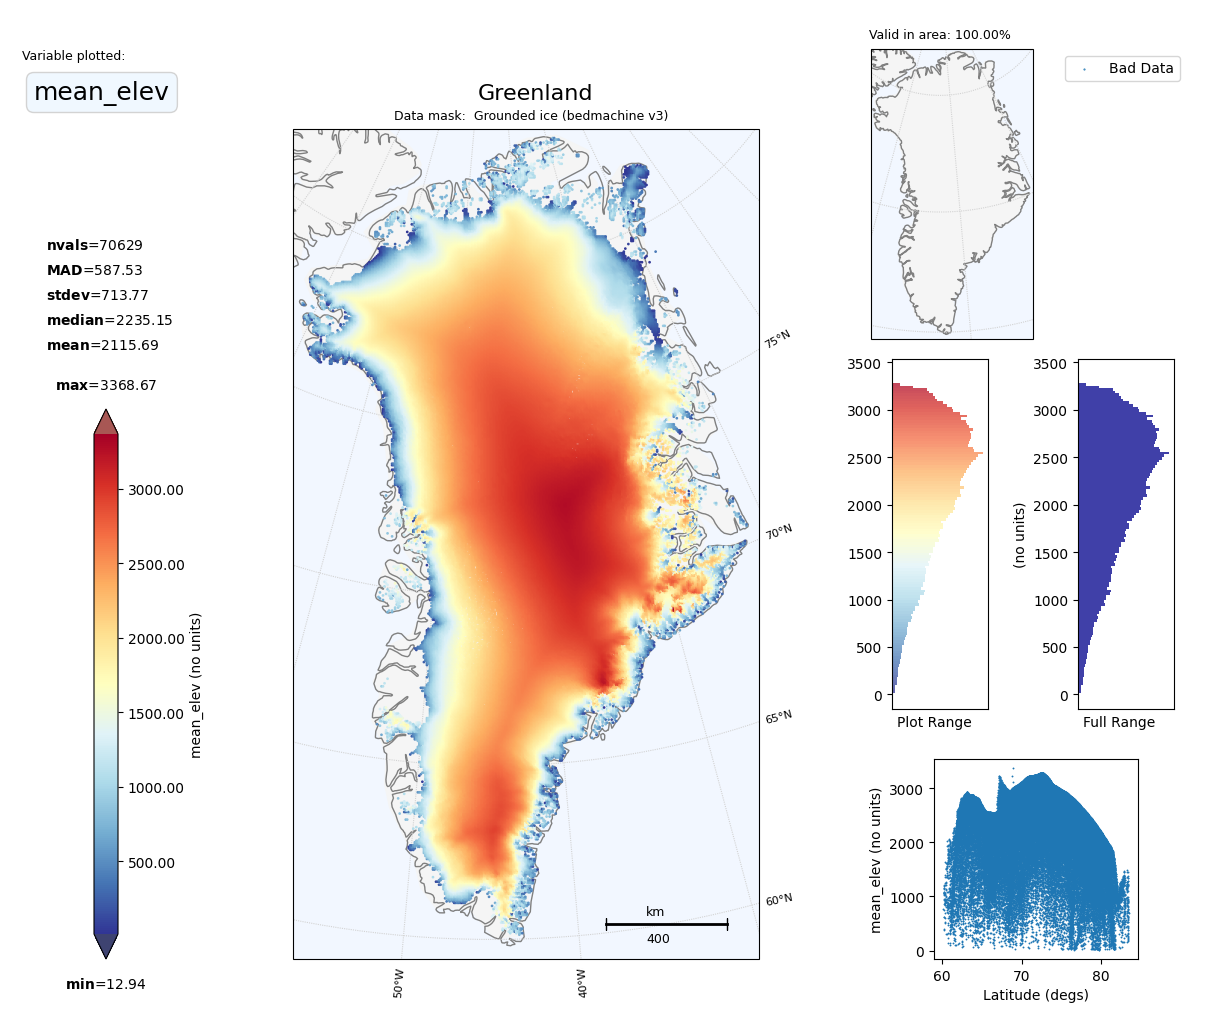

In [105]:

plot_variable(tbl, grid_meta, var_name='mean_elev')

In [108]:
con = duckdb.connect("sec_tools.duckdb")
con.register("compute_stats_per_grid_cell", tbl)  # Register the DataFrame as a DuckDB table
con.execute("CREATE TABLE mean_elev_stats AS SELECT * FROM compute_stats_per_grid_cell")